Overview: Point Sources
-----------------------

So far, the PyAutoLens tutorials have shown strongly lensed galaxies, whose extended surface brightness is lensed into
the awe-inspiring giant arcs and Einstein rings we see in high quality telescope imaging. However, there are many
lenses where the backgound source is not extended but is instead a point-source, for example strongly lensed quasars
and supernovae.

For these objects, we do not want to model the source using a `LightProfile` which implicitly assumes an extended
surface brightness distribution. Instead, we assume that our source is a point source with a centre (y,x). Our
ray-tracing calculations no longer trace extended light rays from the source plane to the image-plane, but instead
now find the locations the point-source's multiple images appear in the image-plane.

Finding the multiple images of a mass model given a (y,x) coordinate in the source plane is an iterative problem
performed in a very different way to ray-tracing a `LightProfile`. In this example, we introduce **PyAutoLens**`s
_PositionSolver_, which does exactly this and thus makes the analysis of strong lensed quasars, supernovae and
point-like source's possible in **PyAutoLens**! we'll also show how these tools allow us to compute the flux-ratios
and time-delays of the point-source.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

import autolens as al
import autolens.plot as aplt

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


To begin, we will create an image of strong lens using a simple `EllipticalIsothermal` mass model and source with an
`EllipticalExponential` light profile. Although we are going to show how **PyAutoLens**`s positional analysis tools 
model point-sources, showing the tools using an extended source will make it visibly clearer where the multiple 
images of the point source are!

Below, we set up a `Tracer` using a `Grid2D`, `LightProfile`, `MassProfile` and two `Galaxy`'s. These objects are 
introduced in the `lensing.py` example script, so if it is unclear what they are doing you should read through that
example first before continuing!

In [2]:
grid = al.Grid2D.uniform(
    shape_native=(100, 100),
    pixel_scales=0.05,  # <- The pixel-scale describes the conversion from pixel units to arc-seconds.
)

isothermal_mass_profile = al.mp.EllipticalIsothermal(
    centre=(0.001, 0.001), einstein_radius=1.0, elliptical_comps=(0.0, 0.111111)
)

exponential_light_profile = al.lp.EllipticalExponential(
    centre=(0.07, 0.07),
    elliptical_comps=(0.2, 0.0),
    intensity=0.05,
    effective_radius=0.2,
)

lens_galaxy = al.Galaxy(redshift=0.5, mass=isothermal_mass_profile)

source_galaxy = al.Galaxy(redshift=1.0, light=exponential_light_profile)

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

Lets plot the image of our strongly lensed source galaxy. By eye, we can clearly see there are four multiple images 
located in a cross configuration, which are the four (y,x) multiple image coordinates we want our positional solver
to find! 

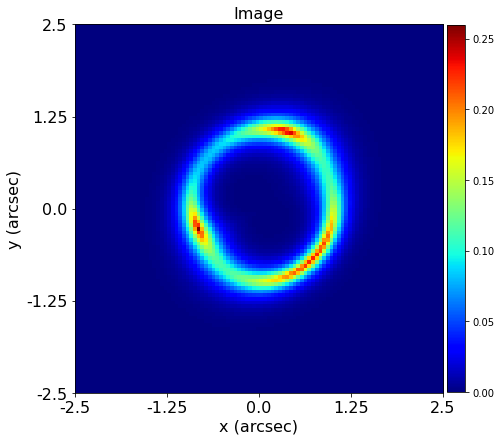

In [3]:
tracer_plotter = aplt.TracerPlotter(tracer=tracer, grid=grid)
tracer_plotter.figures(image=True)

The image above visually illustrates where the source's light traces too in the image-plane. Lets now treat this source
as a point source, by setting up a source galaxy and `Tracer` using the `PointSource` class. 

In [4]:
point_source = al.ps.PointSource(centre=(0.07, 0.07))

source_galaxy = al.Galaxy(redshift=1.0, point=point_source)

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

For a `PointSource`, our goal is to find the (y,x) coordinates in the image-plane that directly map to the centre
of the `PointSource` in the source plane. In this example, we therefore need to compute the 4 image-plane that map
directly to the location (0.07", 0.07") in the source plane.

This is an iterative problem that requires us to use the `PositionsFinder`. 

In [5]:
solver = al.PositionsSolver(
    grid=grid,
    pixel_scale_precision=0.001,
    upscale_factor=2,
    distance_from_source_centre=0.01,
)

We now pass the `Tracer` to the solver. This will then find the image-plane coordinates that map directly to the
source-plane coordinate (0.07", 0.07").

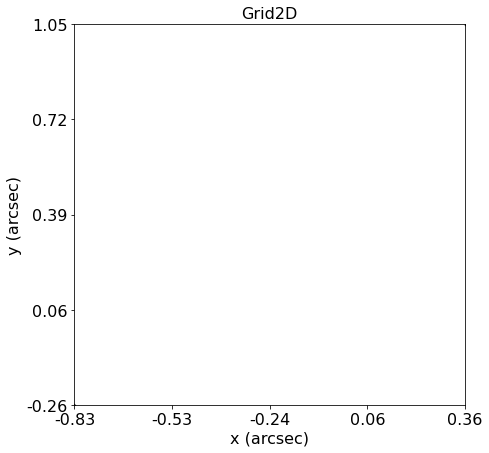

In [6]:
positions = solver.solve(lensing_obj=tracer, source_plane_coordinate=(0.07, 0.07))

grid_plotter = aplt.Grid2DPlotter(grid=positions)
grid_plotter.figure()

At this point, you might be wondering why don't we use the image of the lensed source to compute our multiple images?
Can`t we just find the pixels in the image whose flux is brighter than its neighboring pixels? 

Although this would work, the problem is that for positional modeling we want to know the (y,x) coordinates of the 
multiple images at a significantly higher precision than the `Grid2D` we are plotting the image on. In this example, 
the `Grid2D` has a pixel scale of 0.05", however we want to determine our multiple image positions at scales of 0.01"
or less. We could increase our grid resolutin to 0.01" or below, but this will quickly become very computationally
expensive, thus a bespoke `PositionSolver` is required!